In [4]:
import numpy as np
import pandas as pd
import nilmtk
import pickle
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os
import datetime
from sklearn import preprocessing
import kellyGetData as kgd

offValues = {1:{'kettle':1000,'microwave':500, 'washing machine':100, 'dish washer':6 , 'fridge':50}}

class ReaderTS(object):

    def __init__(self, windows, appliances, time_steps, strd_in, strd_out, 
                    sample_period, flgAggSumScaled=0, flgFilterZeros = 0, 
                    flgScaling=0, trainPer=0.5, valPer=0.25, testPer=0.25):
        self.stride_input = strd_in
        self.stride_output = strd_out
        self.time_steps = time_steps
        self.pTrain = trainPer
        self.pVal = valPer
        self.pTest = testPer
        self.listAppliances = appliances
        self.windows = windows
        self.sample_period = sample_period
        self.flgScaling = flgScaling
        self.flgAggSumScaled = flgAggSumScaled
        self.flgFilterZeros = flgFilterZeros
        self.bin_edges = None
        self.idxFiltered = []
        self.meanTraining = 0.0
        self.stdTraining = 0.0
        assert (trainPer+valPer+testPer) == 1
        
    def rnn_data( self, data, idxStart, idxEnd, apps, stride, labels=False):
        rnn_df = []

        if labels:
            data = data[apps].values
            arrShape = [0,self.time_steps,len(apps)]
        else:
            data = data['use'].values
            arrShape = [0,self.time_steps]

        for i in range(idxStart, idxEnd, stride): # not a-b because we take all the examples
            seqY = data[i:i + self.time_steps]
            if (seqY.shape[0] == self.time_steps):
                rnn_df.append(seqY)
            else:
                continue #pad

        if (len(rnn_df)!=0):
            result = np.array(rnn_df) #shape (batch, x:1/y:apps, lengthSeq)
            return np.squeeze(result) # make it two dimensions if we are just selecting one appliance
        else:
            return np.empty(arrShape)
    
    def calculate_split(self, data):
        '''
        Spliting the data into training, validation and test sets according to the percentage values
        '''
        pRest = self.pVal + self.pTest
        completeInstances = len(data.index)
        indexVal = int(round((self.pTrain*self.stride_input*(completeInstances - self.time_steps) +  
                              pRest*self.stride_output*self.time_steps)/ 
                                (pRest*self.stride_output + self.pTrain*self.stride_input)))
        indexTest = int(indexVal + self.pVal*(completeInstances - indexVal)/pRest)

        #Sabina 50% - 25% - 25%
        return indexVal,indexTest,completeInstances
    
    def split_data(self, dataBuild, indexVal, indexTest, indexEnd,apps):
        train_y = self.rnn_data(dataBuild, 0, indexVal, apps, self.stride_input, labels=True)
        val_y   = self.rnn_data(dataBuild, indexVal, indexTest, apps, self.stride_output, labels=True)
        test_y  = self.rnn_data(dataBuild, indexTest, indexEnd, apps, self.stride_output, labels=True)
        return train_y, val_y, test_y

    def convert3D(self, dataBuild, indexEnd):
        return self.rnn_data(dataBuild, 0, indexEnd, self.listAppliances, self.stride_input, labels=True)
    
    def scaling(self, train, val, test, newShape, thirdDim):
            ##### scaling
        flat_train = np.reshape(train,[-1,thirdDim])
        flat_val = np.reshape(val,[-1,thirdDim])
        flat_test = np.reshape(test,[-1,thirdDim])

        scalerY = preprocessing.StandardScaler().fit(flat_train)

        train = scalerY.transform(flat_train) if flat_train.shape[0]!=0 else train
        train = np.reshape(train, newShape)
        val = scalerY.transform(flat_val) if flat_val.shape[0]!=0 else val
        val = np.reshape(val, newShape)
        test = scalerY.transform(flat_test) if flat_test.shape[0]!=0 else test
        test = np.reshape(test, newShape)
        return train, val, test      

    def filtering_zeros(self,dataset, building, app):
        '''
        Eliminating sequences where all the time_steps are OFF (could be 0 or 0.007, depending on the appliance)
        '''
        sumZero = np.sum(dataset, axis=1)
        idxNonZero = np.where(sumZero>0)
        return dataset[idxNonZero], idxNonZero

    def filtering_Off(self,dataset, building, numApp):
        '''
        Eliminating sequences where all the time_steps are equal to value that can be considered OFF
        '''
        #assert len(self.listAppliances)==len(offValues[building])
        cond=[]

        if (numApp!=-1):
            app = self.listAppliances[numApp]
            goodRows = dataset>offValues[building][app]
        else:
            for idx, app in enumerate(self.listAppliances):
                cond.append(dataset[:,:,idx]>offValues[building][app])#,dataset[:,1]>0]
            condArray = np.array(cond)
            goodRows = np.any(condArray,axis=0) #lloking for any appliance in ON at each time step
        goodRows = np.any(goodRows,axis=1)
        idxNonZero = np.where(goodRows==True)
        print("len index ", len(idxNonZero), " shape ", len(idxNonZero[0]))
        return dataset[idxNonZero], idxNonZero
    
    def prepare_data(self, dataBuild, numApp, building, typeLoad):
        '''
        Spliting to scale over the training
        Filtering zeros before scaling
        Two ways:
            - when requiring just one appliance: spliting the disaggregated, 
                                                filtering zeros from disaggregated and then aggregated 
                                                scaling separetly
            - when requiring all the appliances: spliting the disaggregated,
                                                Calculating aggregated
                                                Filter zeros from aggregated and the disaggregated
                                                Scaling disaggregated
                                                Suming up aggregated from the scaled disaggregated
        '''
        indexVal, indexTest, indexEnd = self.calculate_split(dataBuild)
        print("Indexes: ",indexVal, indexTest, indexEnd)
        self.bin_edges = np.array([0,indexVal, indexTest, indexEnd])
        #Split and sum as if there was no specific appliance selected

        if (typeLoad==0):
            train_y, val_y, test_y = self.split_data(dataBuild, indexVal, indexTest, indexEnd, self.listAppliances)
        else:
            bigSet = self.convert3D(dataBuild,indexEnd)
            indexVal = int(self.pTrain * len(bigSet))
            indexTest = indexVal + int(self.pVal * len(bigSet))
            indexRandom =  np.random.permutation(len(bigSet))
            train_y = bigSet[indexRandom[:indexVal]]
            val_y = bigSet[indexRandom[indexVal:indexTest]]
            test_y = bigSet[indexRandom[indexTest:]]
            
        #sum up to calculate aggregation (x)
        train_x = np.sum(train_y, axis=2)
        val_x   = np.sum(val_y, axis=2)
        test_x  = np.sum(test_y, axis=2)

        print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)
            
        if (numApp != -1):# if one specific appliance is selected
            #plt.figure(1)
            #plt.plot(dataBuild[self.listAppliances[numApp]][indexTest:])
            
            shapeY = [-1,self.time_steps]
            shapeX = [-1,self.time_steps]

            train_y, val_y, test_y = train_y[:,:,numApp], val_y[:,:,numApp], test_y[:,:,numApp]
            
            #Filtering zeros of specific appliance and respective aggregated instance
            if (self.flgFilterZeros==1):
                train_y, idxTrain = self.filtering_Off(train_y, building,numApp)
                val_y, idxVal   = self.filtering_Off(val_y, building,numApp)
                test_y, idxTest  = self.filtering_Off(test_y, building,numApp)

                train_x = train_x[idxTrain]
                val_x   = val_x[idxVal]
                test_x  = test_x[idxTest]

                self.idxFiltered.append(idxTrain)
                self.idxFiltered.append(idxVal)
                self.idxFiltered.append(idxTest)

            #Scaling
            lenApps=1
            train_y, val_y, test_y = self.scaling(train_y, val_y, test_y, shapeY, thirdDim = lenApps)
            if (self.flgAggSumScaled==1):
                pass # See the way to scale all x sets with respect to train_y
            train_x, val_x, test_x = self.scaling(train_x, val_x, test_x, shapeX, thirdDim = 1)

        else:
            lenApps = len(self.listAppliances)
            shapeY = [-1,self.time_steps, lenApps]
            shapeX = [-1,self.time_steps]

            #Filtering aggregated sequence with no information at all
            if (self.flgFilterZeros==1):
                train_y, idyTrain=self.filtering_Off(train_y, building,numApp)
                val_y, idyVal   = self.filtering_Off(val_y, building,numApp)
                test_y, idyTest  = self.filtering_Off(test_y, building,numApp)
                
                #Filtering the same instances in the disaggregated data set
                train_x = train_x[idyTrain]
                val_x   = val_x[idyVal]
                test_x  = test_x[idyTest]

                self.idxFiltered.append(idyTrain)
                self.idxFiltered.append(idyVal)
                self.idxFiltered.append(idyTest)

            #Scaled each disaggregated separetly and recalculating aggregated consumption
            train_y, val_y, test_y = self.scaling(train_y, val_y, test_y, shapeY, thirdDim = lenApps)

            if (self.flgAggSumScaled ==1):
                train_x = np.sum(train_y, axis=2)
                val_x   = np.sum(val_y, axis=2)
                test_x  = np.sum(test_y, axis=2)
            else:
                train_x, val_x, test_x = self.scaling(train_x, val_x, test_x, shapeX, thirdDim = 1)

        return [train_x, val_x, test_x, train_y, val_y, test_y]

    def all_building_data(self,dataset,building, window):
        dfTotal = []
        df_build = pd.DataFrame(columns=['building']+self.listAppliances+['use'])#
        dataset.set_window(*window)
        elec = dataset.buildings[building].elec
        for appliance in self.listAppliances:
            pdAppSeries = pd.Series()
            # Because more than one seems not to be the total number of instances for that window
            serieApp = elec[appliance].power_series(sample_period=self.sample_period, resample=True).next() #pandas.core.series.Series
            if (len(serieApp.index) !=0): # Some buildings may not have all the appliances
                pdAppSeries = pdAppSeries.append(serieApp)
            df_build[appliance] =  pdAppSeries
        sizeBuild = len(df_build.index)
        df_build['building'] = [building for row in range(sizeBuild)]
        df_build['use'] = df_build[self.listAppliances].sum(axis=1)
        return df_build.fillna(0)


    def load_csvdata(self, data_path, numApp, typeLoad=0, num_sequences_per_batch=0, target_inclusion_prob=0.5):#appliances, filename, self.sample_period, windows
        '''
        Parameters:
            data_path
            numApp to indicate wether all the appliances should be read or just one of them
            typeLoad: 0 usual in time split training|val|test
                      1 Kelly's load
                      2 combination with our own min ON

        Returns:
            totalX, totalY two dictionaries with the split of the X and Y in training, validation and testing
        '''

        nilmkt_fileName = os.path.join(data_path, "ukdale.h5")

        if(typeLoad==1 and num_sequences_per_batch==0):
            print("Need to provide number of sequences per batch with kelly sampling")
            return

        if(typeLoad==1):
            numBatches = 1 #keep at 1 for now (1 batch with as many sequences as possible)
            assert self.windows['train'].keys() == self.windows['test'].keys()
            assert self.windows['val'].keys() == self.windows['test'].keys()
            for building_i, window in self.windows['train'].items(): #self.windows.items()
                #Reformat windows to work with kellys code
                #WINDOWS = { 'train': { 1: ("2013-02-01", "2013-11-30")}  }
                #kellyWindow = {'train':{building_i:(window[0],window[1])}}

                if (numApp!=-1):
                    truFileName=data_path+"/pickles/"+str(building_i)+'_'+self.listAppliances[numApp]+'_'+str(num_sequences_per_batch)+'_'+window[0]+'_'+window[1]#fileName[pos:]
                else:
                    truFileName=data_path+"/pickles/"+str(building_i)+'_'+'all'+'_'+str(num_sequences_per_batch)+'_'+window[0]+'_'+window[1]

                try:
                    total = pickle.load( open(truFileName+"_building_k.pickle","rb"))
                    totalX=total[0]
                    totalY=total[1]
                except (OSError, IOError) as e:
                    totalX, totalY, stdIn, stdTar = kgd.getNILMbatches(self.sample_period, nilmkt_fileName, target_inclusion_prob, self.windows, self.listAppliances, self.pTrain, self.pVal, self.pTest, num_sequences_per_batch, self.time_steps, numApp)
                    #this assumes you have a "pickles" directory at the same level as this file
                    with open(truFileName+"_building_k.pickle",'wb') as fX:
                        pickle.dump([totalX, totalY], fX)
            print(totalX['train'].shape, totalX['val'].shape, totalX['test'].shape, totalY['train'].shape, totalY['val'].shape, totalY['test'].shape)                  
            return totalX,totalY
        else:# 0 or 2
            lenApps = len(self.listAppliances)
            shapeY = [0,self.time_steps,lenApps] # (batch, seqLen, apps)
            dataset = nilmtk.DataSet(nilmkt_fileName)
            if (numApp!=-1):
                lenApps = 1
                shapeY = [0,self.time_steps]
            totalX = {'train':np.empty([0,self.time_steps]), 
                        'val':np.empty([0,self.time_steps]),
                        'test':np.empty([0,self.time_steps])}

            totalY = {'train':np.empty(shapeY), 
                        'val':np.empty(shapeY),
                        'test':np.empty(shapeY)}
                    
            for building_i, window in self.windows.items():
                if (numApp!=-1):
                    truFileName=data_path+"/pickles/"+str(building_i)+'_'+self.listAppliances[numApp]+'_'+str(self.time_steps)+'_'+str(self.stride_input)+'_'+window[0]+'_'+window[1]#fileName[pos:]
                else:
                    truFileName=data_path+"/pickles/"+str(building_i)+'_'+'all'+'_'+str(self.time_steps)+'_'+str(self.stride_input)+'_'+window[0]+'_'+window[1]

                try:
                    dataBuild = pickle.load( open(truFileName+"_building.pickle","rb"))
                except (OSError, IOError) as e:
                    dataBuild = self.all_building_data(dataset,building_i, window)
                    #this assumes you have a "pickles" directory at the same level as this file
                    with open(truFileName+"_building.pickle",'wb') as fX:
                        pickle.dump(dataBuild, fX)
                allSetsBuild = self.prepare_data(dataBuild, numApp, building_i, typeLoad)
                totalX['train'] = np.concatenate((totalX['train'], allSetsBuild[0]),axis=0)
                totalX['val'] = np.concatenate((totalX['val'], allSetsBuild[1]),axis=0)
                totalX['test'] = np.concatenate((totalX['test'], allSetsBuild[2]),axis=0)
                totalY['train'] = np.concatenate((totalY['train'], allSetsBuild[3]),axis=0)
                totalY['val'] = np.concatenate((totalY['val'], allSetsBuild[4]),axis=0)
                totalY['test'] = np.concatenate((totalY['test'], allSetsBuild[5]),axis=0)

            print(totalX['train'].shape, totalX['val'].shape, totalX['test'].shape, totalY['train'].shape, totalY['val'].shape, totalY['test'].shape)                  
            return totalX, totalY

    def build_dict_instances_plot(self,listDates, sizeBatch, TestSize):
      maxBatch = TestSize/sizeBatch  - 1
      listInst = []
      for strDate in listDates:
        initialDate = datetime.datetime.strptime(self.windows[1][0], '%Y-%m-%d')
        targetDate = datetime.datetime.strptime(strDate, '%Y-%m-%d %H:%M')
        nInstance = (targetDate - initialDate).total_seconds()/6
        listInst.append(nInstance)

      instancesPlot = {}
      tupBinsOffset = []
      print(listInst)
      for inst in listInst:
        print(self.bin_edges)
        if (self.bin_edges[2]< inst and inst<self.bin_edges[3]): # If the instance is in the test set
          offSet = int((inst - self.bin_edges[2])/self.time_steps)
          tupBinsOffset.append((2,offSet))
      print(tupBinsOffset)
      dictInstances = {}
      for tupIns in tupBinsOffset:
        smallerIndexes = np.array(self.idxFiltered[tupIns[0]]) #Convert the indexs (tuples) in an array
        tupNumberSmaller = np.where(smallerIndexes<tupIns[1]) #Find the number of indexes that are smaller than the offset
        indexAfterFilter = len(tupNumberSmaller[0])
        nBatch = int(indexAfterFilter/sizeBatch) - 1
        indexAfterBatch =  (indexAfterFilter % sizeBatch) -1
        if (nBatch <= maxBatch):
          if nBatch in dictInstances:
            dictInstances[nBatch].append(int(indexAfterBatch))
          else:
            dictInstances[nBatch] = [int(indexAfterBatch)]
      print(dictInstances)
      return dictInstances

In [5]:
appliances = [ 'kettle','microwave', 'washing machine', 'dish washer' , 'fridge']#
#windows = {1:("2014-02-01", "2014-06-01")}
windows = {'train': {1: ("2014-02-27", "2014-08-27")}, 'test':{1:("2014-08-27", "2014-10-27")}, 'val':{1:("2014-10-27", "2014-12-27")}}

reader = ReaderTS(windows, appliances, 20, 20, 20, 6,flgAggSumScaled=1, flgFilterZeros = 1,
                        flgScaling=1, trainPer=0.5, valPer=0.25, testPer=0.25)
#dataset= nilmtk.DataSet('datasets/ukdale.h5')

In [4]:
building = reader.all_building_data(dataset,1,("2014-02-01", "2015-02-01"))

/home/gissella/Documents/Research/Disaggregation/UK-DALE/nilmtk/nilmtk/utils.py:391: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=20)
  data = data.resample(**resample_kwargs)


KeyboardInterrupt: 

In [6]:
result1 = reader.load_csvdata(data_path='/home/gissella/Documents/Research/Disaggregation/UK-DALE/datasets', numApp=-1, typeLoad=1, num_sequences_per_batch=200, target_inclusion_prob=0.5)

not implemented


ValueError: need more than 2 values to unpack

In [7]:
building.describe()

,building,kettle,microwave,washing machine,dish washer,fridge,use
count,5256000.0,5.256000e+06,5.256000e+06,5.256000e+06,5.256000e+06,5.256000e+06,5.256000e+06
mean,1.0,1.726316e+01,1.260192e+01,3.273589e+01,1.686577e+01,4.232203e+01,1.217888e+02
std,0.0,1.941983e+02,1.314005e+02,2.200458e+02,1.817632e+02,5.397336e+01,3.864198e+02
min,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.0,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00
50%,1.0,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00
75%,1.0,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,8.900000e+01,9.300000e+01
max,1.0,3.948000e+03,3.191000e+03,3.995000e+03,3.304000e+03,2.572000e+03,7.562000e+03


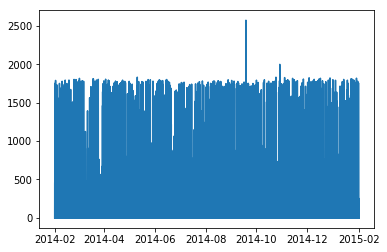

In [58]:
plt.figure(1)
plt.plot(building['fridge'])

In [24]:
#buildingFilter = building.loc[building.index>'2014-06-01']
#buildingFilter.loc[building['kettle']>1000]
building.loc[(building['kettle']>1000) & (building['microwave']>500) & (building['washing machine']>100) & (building['dish washer']>6) ]

,building,kettle,microwave,washing machine,dish washer,fridge,use
2014-09-28 11:02:18+01:00,1,2301.0,1357.0,128.0,2229.0,0.0,6015.0
2014-09-28 11:02:24+01:00,1,2260.0,1352.0,209.0,2249.0,0.0,6070.0
2014-09-28 11:02:30+01:00,1,2230.0,1355.0,182.0,2249.0,0.0,6016.0
2014-09-28 11:02:36+01:00,1,2246.0,1347.0,199.0,2219.0,0.0,6011.0
2014-09-28 11:02:42+01:00,1,2246.0,1345.0,186.0,2257.0,0.0,6034.0
2014-09-28 11:02:48+01:00,1,2250.0,1345.0,173.0,2240.0,0.0,6008.0
2014-09-28 11:02:54+01:00,1,2253.0,1346.0,173.0,2219.0,0.0,5991.0
2014-09-28 11:03:06+01:00,1,2222.0,1334.0,163.0,2209.0,0.0,5928.0
2014-09-28 11:03:18+01:00,1,2249.0,1328.0,193.0,2250.0,0.0,6020.0


In [26]:
building.columns

Index([u'building', u'kettle', u'microwave', u'washing machine',
       u'dish washer', u'fridge', u'use'],
      dtype='object')

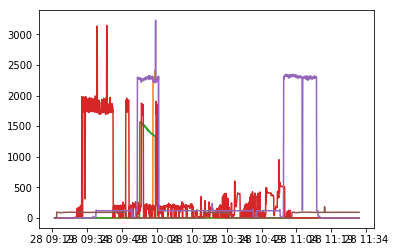

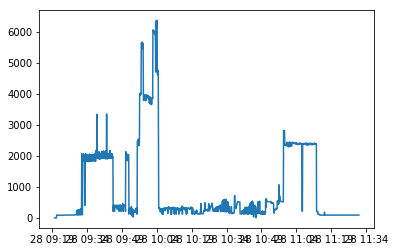

In [34]:
#building2 = building
#building2.drop(['use'])
plt.figure(2)
plt.plot(building[['building', 'kettle', 'microwave', 'washing machine','dish washer', 'fridge']]['2014-09-28 10:20':'2014-09-28 12:30'])
plt.figure(3)
plt.plot(building['use']['2014-09-28 10:20':'2014-09-28 12:30'])
#plt.figure(4)
#plt.plot(building['fridge']['2014-02-01 00:00':'2014-02-01 05:10'])


In [63]:
building['fridge']['2014-02-01 03:00':'2014-02-01 03:20']

2014-02-01 03:00:00+00:00    87.0
2014-02-01 03:00:06+00:00    87.0
2014-02-01 03:00:12+00:00    87.0
2014-02-01 03:00:18+00:00    87.0
2014-02-01 03:00:24+00:00    87.0
2014-02-01 03:00:30+00:00    87.0
2014-02-01 03:00:36+00:00    87.0
2014-02-01 03:00:42+00:00    87.0
2014-02-01 03:00:48+00:00    87.0
2014-02-01 03:00:54+00:00    87.0
2014-02-01 03:01:00+00:00    86.0
2014-02-01 03:01:06+00:00    86.0
2014-02-01 03:01:12+00:00    86.0
2014-02-01 03:01:18+00:00    86.0
2014-02-01 03:01:24+00:00    86.0
2014-02-01 03:01:30+00:00    87.0
2014-02-01 03:01:36+00:00    86.0
2014-02-01 03:01:42+00:00    86.0
2014-02-01 03:01:48+00:00    86.0
2014-02-01 03:01:54+00:00    86.0
2014-02-01 03:02:00+00:00    85.0
2014-02-01 03:02:06+00:00    85.0
2014-02-01 03:02:12+00:00    86.0
2014-02-01 03:02:18+00:00    86.0
2014-02-01 03:02:24+00:00    86.0
2014-02-01 03:02:30+00:00    86.0
2014-02-01 03:02:36+00:00    86.0
2014-02-01 03:02:42+00:00    86.0
2014-02-01 03:02:48+00:00    85.0
2014-02-01 03:

In [39]:
import matplotlib.pyplot as plt
#result1.describe()
bins = [0,1,50,100,1000,2000,3000,4000]
hist,edges = np.histogram(result1['kettle'],bins)

In [40]:
hist#[  737674, 20163787,      312,     5095,     1682,   129816, 32]

array([  737674, 20163787,      312,     5095,     1682,   129816,
             32])

In [2]:
goodPlot = result1.loc[ (result1['fridge']>100) &  (result1['kettle']>50)  &  (result1['kettle']>50) ]
#toPlot = data.loc['2015-08-20 01:00:00':'2015-08-20 02:00:00']

NameError: name 'result1' is not defined